# Прогнозирование рейтинга отеля на Booking

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import time
import re

In [ ]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [ ]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

#Подгрузка и анализ данных



```
Признаки

    hotel_address - адрес отеля
    review_date - дата, когда рецензент разместил соответствующий отзыв.
    average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
    hotel_name - название отеля
    reviewer_nationality - национальность рецензента
    negative_review - отрицательный отзыв, который рецензент дал отелю.
    review_total_negative_word_counts - общее количество слов в отрицательном отзыв
    positive_review - положительный отзыв, который рецензент дал отелю
    review_total_positive_word_counts - общее количество слов в положительном отзыве
    reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
    total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
    total_number_of_reviews - общее количество действительных отзывов об отеле
    tags - теги, которые рецензент дал отелю.
    days_since_review - продолжительность между датой проверки и датой очистки
    additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
    lat - широта отеля
    lng - долгота отеля

```



In [ ]:
#DATA_DIR = '/kaggle/input/sf-booking/'
DATA_DIR = ''
df_train = pd.read_csv(DATA_DIR+'hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'submission.csv') # самбмишн

In [ ]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [ ]:
#pip install pandas-profiling -U

In [ ]:
# для предварительного анализа датасета будем использовать Pandas-profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(data, title="Booking_hotels")

In [ ]:
profile

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


In [ ]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,49.442439,2.823803,0.749999,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.466325,4.579425,0.433014,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.214662,-0.143372,0.250000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,0.010607,1.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,51.516288,4.834443,1.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.000000,10.000000


In [ ]:
data.describe(include=[object])  

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,515738,515738,515738,515738,515738,515738,515738,515738
unique,1493,731,1492,227,330011,412601,55242,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,4789,2585,4789,245246,127890,35946,5101,2585


Вывод:имеем 515738 строк, 336 строк-дубликатов, 8 - категориальных (sample не учитываем) и 9 - числовых признаков. Пропущенные значения имеют признаки lat и lng. Наблюдается сильная корреляция между additional_number_of_scoring и total_number_of_reviews. Половина рецензентов из United Kingdom. 

# Очистка и обработка данных

**Признак Tegs. Смотрим уникальные значения. Кодируем их**

In [ ]:
df1 = data.copy() #вспомогательный датасет

In [ ]:
def re_func(num_tags):
    found = re.findall("'[^\'](.+?)[^\']'", num_tags)
    return found

In [ ]:
df1['tags'] = df1['tags'].apply(re_func)
df1 = df1.explode('tags')

In [ ]:
df1['tags'].value_counts().head(15)

Leisure trip                      417778
Submitted from a mobile device    307640
Couple                            252294
Stayed 1 night                    193645
Stayed 2 nights                   133937
Solo traveler                     108545
Stayed 3 nights                    95821
Business trip                      82939
Group                              65392
Family with young children         61015
Stayed 4 nights                    47817
Double Room                        35207
Standard Double Room               32248
Superior Double Room               31393
Family with older children         26349
Name: tags, dtype: int64

**Выделяем основных 10 тегов**

In [ ]:
def re_func_teg(num_tags):
    found = re.findall("'[^\'](.+?)[^\']'", num_tags)
    return ' '.join(found)

In [ ]:
data['tags'] = data['tags'].apply(re_func_teg)

In [ ]:
data['leisure_trip'] = 0
data['leisure_trip'] = data['tags'].apply(lambda x: 1 if x.find('Leisure trip')!=-1 else 0)

In [ ]:
data['business_trip'] = 0
data['business_trip'] = data['tags'].apply(lambda x: 1 if x.find('Business trip')!=-1 else 0)

In [ ]:
data['submitted_from_mobile_device'] = 0
data['submitted_from_mobile_device'] = data['tags'].apply(lambda x: 1 if x.find('Submitted from a mobile device')!=-1 else 0)

In [ ]:
data['couple'] = 0
data['couple'] = data['tags'].apply(lambda x: 1 if x.find('Couple')!=-1 else 0)

In [ ]:
data['group'] = 0
data['group'] = data['tags'].apply(lambda x: 1 if x.find('Group')!=-1 else 0)

In [ ]:
data['family_with_young_children'] = 0
data['family_with_young_children'] = data['tags'].apply(lambda x: 1 if x.find('Family with young children')!=-1 else 0)

In [ ]:
data['stayed_1_night'] = 0
data['stayed_1_night'] = data['tags'].apply(lambda x: 1 if x.find('Stayed 1 night')!=-1 else 0)

In [ ]:
data['stayed_2_night'] = 0
data['stayed_2_night'] = data['tags'].apply(lambda x: 1 if x.find('Stayed 2 night')!=-1 else 0)

In [ ]:
data['stayed_3_night'] = 0
data['stayed_3_night'] = data['tags'].apply(lambda x: 1 if x.find('Stayed 3 night')!=-1 else 0)

In [ ]:
data['solo_traveler'] = 0
data['solo_traveler'] = data['tags'].apply(lambda x: 1 if x.find('Solo traveler')!=-1 else 0)

In [ ]:
# удалим столбец  tags
data = data.drop(['tags'], axis=1)

In [ ]:
data.head(5)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,leisure_trip,business_trip,submitted_from_mobile_device,couple,group,family_with_young_children,stayed_1_night,stayed_2_night,stayed_3_night,solo_traveler
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,1,0,0,1,0,0,0,1,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,1,0,0,0,1,0,1,0,0,0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,0,1,1,0,0,0,1,0,0,1
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,...,1,0,0,1,0,0,1,0,0,0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,...,0,1,1,0,0,0,0,1,0,1


**Признак hotel_address. Выделим названия городов и стран из адреса**

In [ ]:
data['country'] = data['hotel_address'].apply(lambda x: 'United Kingdom' if x.endswith('United Kingdom') else x.split()[-1])
data['city'] = data['hotel_address'].apply(lambda x: 'London' if x.endswith('United Kingdom') else x.split()[-2])

In [ ]:
data['country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: country, dtype: int64

In [ ]:
data['city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64

Выводы: имеем дело с 6 странами и с 6 городами в этих странах. Эти признаки по сути одинаковы. Удаляем признаки hotel_address и country. Кодируем city с помощью LabelEncoder

In [ ]:
data = data.drop(['hotel_address', 'country'], axis=1)

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
data['city'] = LabelEncoder().fit_transform(data['city'])

In [ ]:
data.head(5)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,business_trip,submitted_from_mobile_device,couple,group,family_with_young_children,stayed_1_night,stayed_2_night,stayed_3_night,solo_traveler,city
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,0,0,1,0,0,0,1,0,0,3
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,0,0,0,1,0,1,0,0,0,0
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,1,1,0,0,0,1,0,0,1,1
3,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,...,0,0,1,0,0,1,0,0,0,3
4,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,...,1,1,0,0,0,0,1,0,1,0


**Признак reviewer_nationality**

In [ ]:
len(data['reviewer_nationality'].unique()) # количество национальностей туристов

227

In [ ]:
data['reviewer_nationality'].value_counts().head(10)

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
Name: reviewer_nationality, dtype: int64

In [ ]:
# оставим первые десять, самые частые национальности среди туристов
most_frequent_nat= data['reviewer_nationality'].value_counts().nlargest(10).index
data['reviewer_nationality'] = data['reviewer_nationality'].apply(
    lambda x:x if x in most_frequent_nat else 'Other')

In [ ]:
# кодируем признак reviewer_nationality
# from sklearn import preprocessing
#from sklearn.preprocessing import LabelEncoder
data['reviewer_nationality'] = LabelEncoder().fit_transform(data['reviewer_nationality'])

In [ ]:
data.head(5)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,business_trip,submitted_from_mobile_device,couple,group,family_with_young_children,stayed_1_night,stayed_2_night,stayed_3_night,solo_traveler,city
0,904,7/21/2017,8.1,Hotel Da Vinci,8,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,0,0,1,0,0,0,1,0,0,3
1,612,12/12/2016,8.6,Urban Lodge Hotel,10,No tissue paper box was present at the room,10,5018,No Positive,0,...,0,0,0,1,0,1,0,0,0,0
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,10,Pillows,3,351,Nice welcoming and service,5,...,1,1,0,0,0,1,0,0,1,1
3,241,10/17/2015,9.1,Hotel Principe Di Savoia,9,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,...,0,0,1,0,0,1,0,0,0,3
4,834,5/16/2016,9.1,Hotel Esther a,8,No Negative,0,4687,Lovely hotel v welcoming staff,7,...,1,1,0,0,0,0,1,0,1,0


**Признаки review_date, days_since_review**

In [ ]:
data['review_date'] = pd.to_datetime(data['review_date'])

In [ ]:
# Выделим из даты день, месяц, год
data['day'] = data['review_date'].dt.day.astype(int)
data['month'] = data['review_date'].dt.month.astype(int)
data['year'] = data['review_date'].dt.year.astype(int)

In [ ]:
# Выделим из даты день недели и выходные дни
data['day_of_week'] = data['review_date'].dt.dayofweek.astype(int)
data['is_weekend'] = data['day'].apply(lambda x: 1 if x>4 else 0)

In [ ]:
# Выделим из даты поры года
data['is_spring'] = data['month'].apply(lambda x: 1 if x in [3,4,5] else 0)
data['is_summer'] = data['month'].apply(lambda x: 1 if x in [6,7,8] else 0)
data['is_autumn'] = data['month'].apply(lambda x: 1 if x in [9,10,11] else 0)
data['is_winter'] = data['month'].apply(lambda x: 1 if x in [12,1,2] else 0)

In [ ]:
# удалим столбец review_date
data.drop(['review_date'], inplace=True, axis=1)

In [ ]:
# обработаем признак days_since_review
def since_review_func(x):
    string = str(x)
    return string.split()[0]

In [ ]:
data['days_since_review'] = data['days_since_review'].apply(since_review_func).astype(int)

In [ ]:
data.head(5)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,city,day,month,year,day_of_week,is_weekend,is_spring,is_summer,is_autumn,is_winter
0,904,8.1,Hotel Da Vinci,8,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,...,3,21,7,2017,4,1,0,1,0,0
1,612,8.6,Urban Lodge Hotel,10,No tissue paper box was present at the room,10,5018,No Positive,0,7,...,0,12,12,2016,0,1,0,0,0,1
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,10,Pillows,3,351,Nice welcoming and service,5,15,...,1,26,11,2015,3,1,0,0,1,0
3,241,9.1,Hotel Principe Di Savoia,9,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,...,3,17,10,2015,5,1,0,0,1,0
4,834,9.1,Hotel Esther a,8,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,...,0,16,5,2016,0,1,1,0,0,0


**Признаки, относящиеся к отзывам**

In [ ]:
# найдем % положительных и отрицательных отзывов на основании количества слов
data['%pos_word'] = data['review_total_positive_word_counts'] / (data[
  'review_total_positive_word_counts'] + data['review_total_negative_word_counts'])
data['%neg_word'] = data['review_total_negative_word_counts'] / (data[
  'review_total_positive_word_counts'] + data['review_total_negative_word_counts'])

# Так как есть строки с нулевым количеством слов в положительном отзыве и
# нулевым количеством слов в отрицательном отзыве появляются пробелы из-за
# невозможности деления на ноль. Заполним пропуски нулями
data['%pos_word'] = data['%pos_word'].fillna(0)
data['%neg_word'] = data['%neg_word'].fillna(0)

In [ ]:
# удаляем столбцы: negative_review, review_total_negative_word_counts,
# positive_review, review_total_positive_word_counts
data.drop(['negative_review', 'review_total_negative_word_counts', 
          'positive_review', 'review_total_positive_word_counts'], inplace=True, axis=1)

In [ ]:
data.head(5)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,total_number_of_reviews,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,sample,...,month,year,day_of_week,is_weekend,is_spring,is_summer,is_autumn,is_winter,%pos_word,%neg_word
0,904,8.1,Hotel Da Vinci,8,16670,1,13,45.533137,9.171102,0,...,7,2017,4,1,0,1,0,0,0.54386,0.45614
1,612,8.6,Urban Lodge Hotel,10,5018,7,234,52.385649,4.834443,0,...,12,2016,0,1,0,0,0,1,0.00000,1.00000
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,10,351,15,616,41.393192,2.161520,0,...,11,2015,3,1,0,0,1,0,0.62500,0.37500
3,241,9.1,Hotel Principe Di Savoia,9,1543,9,656,45.479888,9.196298,0,...,10,2015,5,1,0,0,1,0,1.00000,0.00000
4,834,9.1,Hotel Esther a,8,4687,2,444,52.370545,4.888644,0,...,5,2016,0,1,1,0,0,0,1.00000,0.00000


**Проверяем датасет**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 33 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   reviewer_nationality                        515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         512470 non-null  float64
 8   lng                                         512470 non-null  float64
 9   sample                                      515738 non-null  int64  
 

In [ ]:
# Остались hotel_name и географические координаты отеля.
# Так как у нас есть признак города, то удаляем столбцы
# hotel_name, lat, lng
data.drop(['hotel_name', 'lat', 'lng'], inplace=True, axis=1)

In [ ]:
data.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   reviewer_nationality                        515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   days_since_review                           515738 non-null  int64  
 6   sample                                      515738 non-null  int64  
 7   reviewer_score                              515738 non-null  float64
 8   leisure_trip                                515738 non-null  int64  
 9   business_trip                               515738 non-null  int64  
 

In [ ]:
data.columns

Index(['additional_number_of_scoring', 'average_score', 'reviewer_nationality',
       'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given',
       'days_since_review', 'sample', 'reviewer_score', 'leisure_trip',
       'business_trip', 'submitted_from_mobile_device', 'couple', 'group',
       'family_with_young_children', 'stayed_1_night', 'stayed_2_night',
       'stayed_3_night', 'solo_traveler', 'city', 'day', 'month', 'year',
       'day_of_week', 'is_weekend', 'is_spring', 'is_summer', 'is_autumn',
       'is_winter', '%pos_word', '%neg_word'],
      dtype='object')

# Нормализация данных

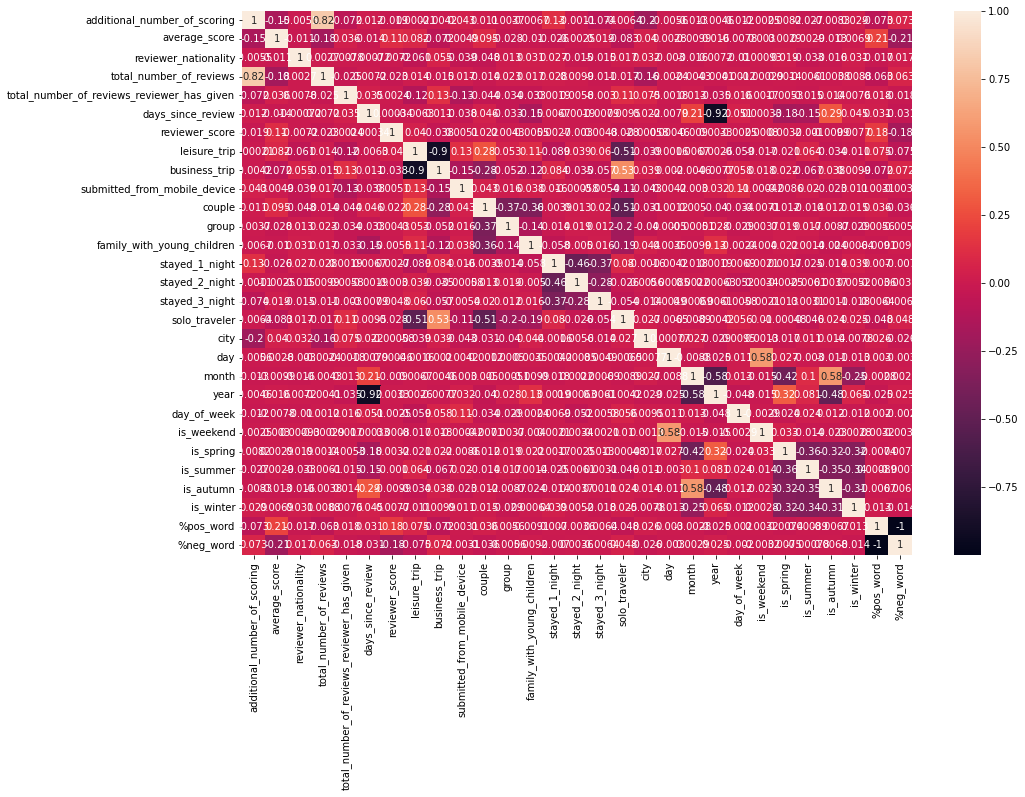

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [ ]:
# числовые признаки
num_cols = ['additional_number_of_scoring', 'average_score', 
            'total_number_of_reviews', 
            'total_number_of_reviews_reviewer_has_given',
            'days_since_review', '%pos_word', '%neg_word']

# категориальные признаки
cat_cols = ['reviewer_nationality', 'leisure_trip',
            'business_trip', 'submitted_from_mobile_device',
            'couple', 'group', 'family_with_young_children', 
            'stayed_1_night', 'stayed_2_night', 'stayed_3_night', 
            'solo_traveler', 'city', 'day', 'month', 'year',
            'day_of_week', 'is_weekend', 'is_spring', 'is_summer', 
            'is_autumn', 'is_winter']      

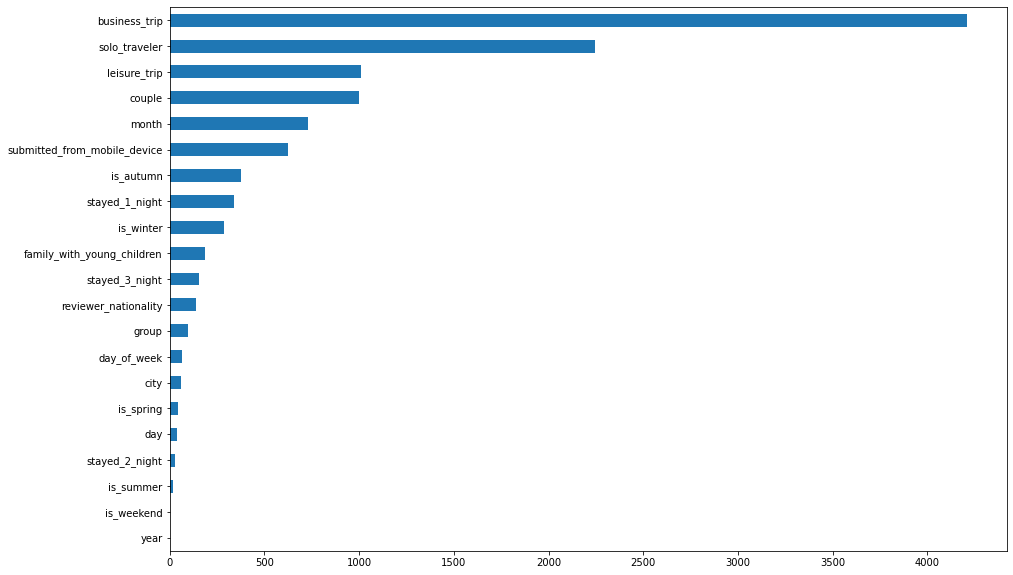

In [ ]:
from sklearn.feature_selection import chi2 # хи-квадрат
import matplotlib.pyplot as plt
%matplotlib inline

# Для оценки значимости категориальных переменных будем использовать 
# непараметрический тест хи-квадрат.
# Выведем значения хи-квадрат на графике:

y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = data.query('sample == 1').drop(['sample'], axis=1)[cat_cols]

plt.rcParams['figure.figsize'] = (15,10)
imp_cat = pd.Series(chi2(X, y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

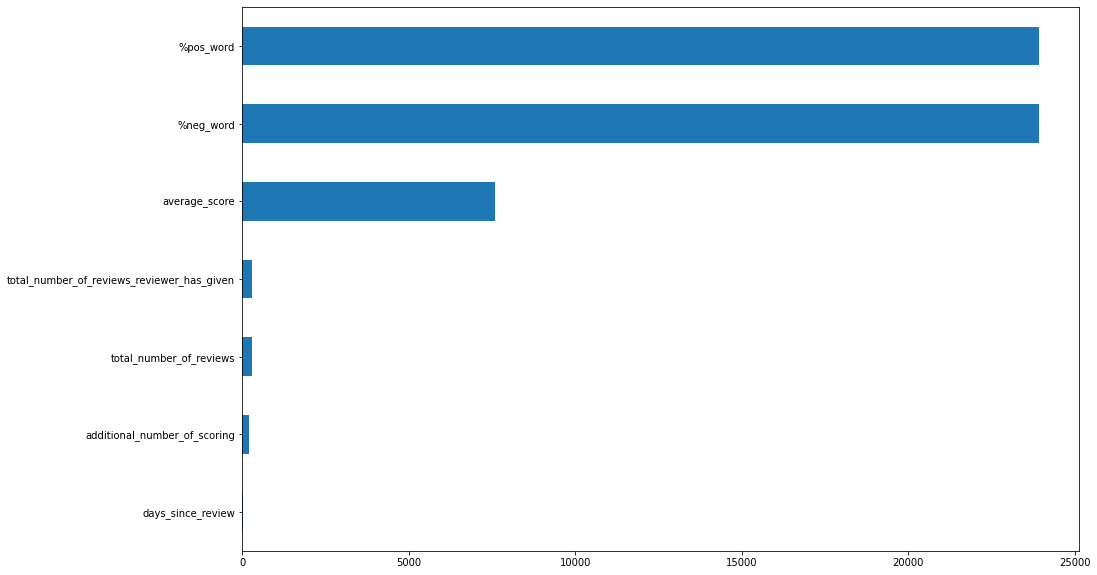

In [ ]:
from sklearn.feature_selection import f_classif # anova
# Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn.
# В основе метода оценки значимости переменных лежит анализ (ANOVA).
# В качестве меры значимости будем использовать значение f-статистики - чем значение статистики выше, тем меньше 
# вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.

y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = data.query('sample == 1').drop(['sample'], axis=1)[num_cols]

imp_num = pd.Series(f_classif(X, y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [ ]:
import plotly.express as px

In [ ]:
# чтобы исключить мультиколлениарность удалим признаки, сильно коррелирующий с другим признаком
pivot = data.corr()
pivot = pivot.drop('sample', axis=0)
pivot = pivot.drop('sample', axis=1)
for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.72 or x == 1) else x)
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')
fig = px.imshow(pivot)

fig.show()

In [ ]:
# удаляем признаки с максимальной корреляцией
counter = 0
for lower_bound in np.linspace(0.98, 0.72, num=14):
    for col in pivot:
        if pivot[col].max() > lower_bound or pivot[col].min() < -lower_bound:
            pivot = pivot.drop(col, axis=0)
            pivot = pivot.drop(col, axis=1)
            data = data.drop(col, axis=1)
            counter += 1
            print('Deleted ', col)
print('Deleted', counter, 'columns')

Deleted  %pos_word
Deleted  days_since_review
Deleted  leisure_trip
Deleted  additional_number_of_scoring
Deleted 4 columns


# Обучение модели

In [ ]:
# Выделим часть для обучения
train_data = data.query('sample == 1').drop(['sample'], axis=1)

# Выделим тестовую часть
test_data = data.query('sample == 0').drop(['sample'], axis=1)

# целевая переменная
y = train_data.reviewer_score.values

# данные с информацией об отелях
X = train_data.drop(['reviewer_score'], axis=1)

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем датасеты
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 25), (386803, 25), (386803, 24), (309442, 24), (77361, 24))

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
%%time

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.6s


CPU times: user 7min 14s, sys: 2.96 s, total: 7min 17s
Wall time: 3min 47s


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.5s finished


In [ ]:
# Сравниваем по метрикам MAE и MAPE предсказанные значения (y_pred) с реальными 
# (y_test) и смотрим насколько они в среднем отличаются

# Mean Absolute Error (MAE) - Среднее отклонение предсказанных значений от фактических.
# Mean Absolute Percentage Error (MAPE) - Средняя абсолютная ошибка регрессии в процентах
print('MAE:  ', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE: ', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAE:   0.9527418993471749
MAPE:  0.13770882239777663


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAPE: 13.770882239777663


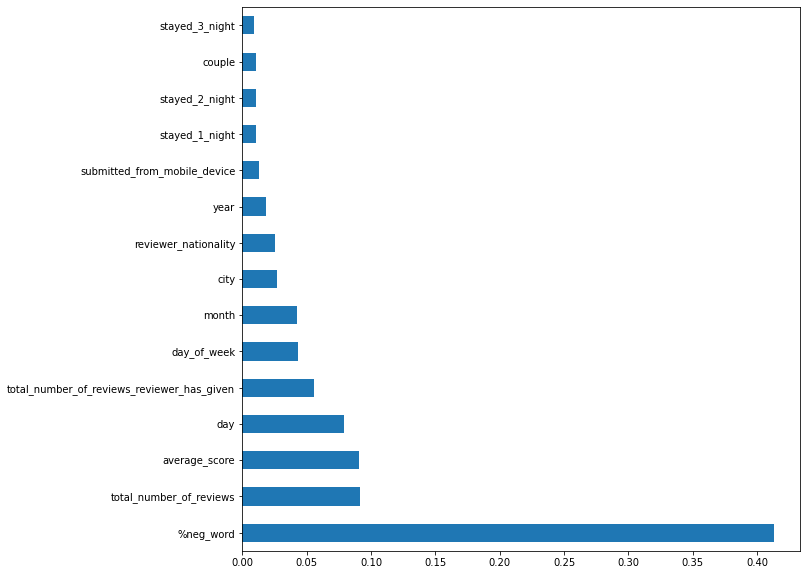

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [ ]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [ ]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    6.4s finished


In [ ]:
predict_submission

array([8.543, 6.557, 8.135, ..., 7.699, 9.355, 7.006])

In [ ]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.543,488440
1,6.557,274649
2,8.135,374688
3,9.656,404352
4,9.652,451596
5,9.000,302161
6,8.035,317079
7,7.447,13963
8,9.142,159785
9,7.600,195089
